In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
#os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".25"

import torch
torch.multiprocessing.set_start_method('spawn')

In [4]:
# Add parent folder to path (to run this file from subdirectories)
(parent_folder_path, current_dir) = os.path.split(os.path.abspath(''))
sys.path.append(parent_folder_path)

# add git submodule to path to allow imports to work
submodule_name = 'AlphaTrade'
(parent_folder_path, current_dir) = os.path.split(os.path.abspath(''))
sys.path.append(os.path.join(parent_folder_path, submodule_name))

from gymnax_exchange.jaxob.jorderbook import OrderBook
import gymnax_exchange.jaxob.JaxOrderbook as job

In [5]:
from argparse import Namespace
from glob import glob
import numpy as onp
import pandas as pd
from functools import partial
from typing import Union, Optional
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax.nn import one_hot
from jax import random
from jax.scipy.linalg import block_diag
from flax import jax_utils
from flax.training import checkpoints
import orbax

#from lob.lob_seq_model import BatchLobPredModel
from lob.train_helpers import create_train_state, eval_step, prep_batch, cross_entropy_loss, compute_accuracy
from s5.ssm import init_S5SSM
from s5.ssm_init import make_DPLR_HiPPO
from s5.dataloading import make_data_loader
from lob_seq_model import LobPredModel
from encoding import Vocab, Message_Tokenizer
from lobster_dataloader import LOBSTER_Dataset, LOBSTER_Subset, LOBSTER_Sampler, LOBSTER

import preproc
import inference
import validation_helpers as valh
from lob.init_train import init_train_state, load_checkpoint, load_args_from_checkpoint

# necessary for flax checkpoints to be loaded in jupyter notebook
import nest_asyncio
nest_asyncio.apply()

## Model

In [6]:
n_messages = 500
v = Vocab()
n_classes = len(v)
seq_len = n_messages * Message_Tokenizer.MSG_LEN
book_dim = 501 #b_enc.shape[1]
book_seq_len = n_messages

rng = jax.random.PRNGKey(42)
rng, rng_ = jax.random.split(rng)

In [7]:
#ckpt_path = '../checkpoints/brisk-surf-147_yc8wpyi3/'
#ckpt_path = '../checkpoints/scarlet-voice-168_iqq80fnp/'
# ckpt_path = '../checkpoints/ancient-dawn-506_ykmjf41l/'  # FLAIR Node trained on 0.5 years of GOOG
ckpt_path = '../checkpoints/bumbling-sun-108_idstu91x/'  # new encoding
# TODO: copy over new train state from FLAIR Node (new encoding on 0.5 years of GOOG)

In [8]:
args = load_args_from_checkpoint(ckpt_path)
args

Namespace(C_init='trunc_standard_normal', USE_WANDB=True, activation_fn='half_glu1', batchnorm=True, bidirectional=True, blocks=8, bn_momentum=0.95, book_depth=500, book_transform=True, bsz=12, clip_eigs=True, conj_sym=True, cosine_anneal=True, d_model=128, dataset='lobster-prediction', dir_name='./data/new_enc', discretization='zoh', dt_global=False, dt_max=0.1, dt_min=0.001, early_stop_patience=1000, epochs=200, jax_seed=42, lr_factor=1.0, lr_min=0, lr_patience=1000000, masking='causal', mode='pool', msg_seq_len=500, n_book_post_layers=1, n_book_pre_layers=1, n_data_workers=0, n_layers=6, n_message_layers=2, num_devices=1, opt_config='standard', p_dropout=0.2, prenorm=True, reduce_factor=1.0, restore=None, restore_step=None, ssm_lr_base=0.0005, ssm_size_base=256, use_book_data=True, use_simple_book=False, wandb_entity='peer-nagy', wandb_project='LOBS5', warmup_end=1, weight_decay=0.05)

In [9]:
# scale down to single GPU, single sample inference
args.bsz = 1
args.num_devices = 1

batchnorm = args.batchnorm

In [10]:
# load train state from disk

new_train_state, model_cls = init_train_state(
    args,
    n_classes=n_classes,
    seq_len=seq_len,
    book_dim=book_dim,
    book_seq_len=book_seq_len,
)

ckpt = load_checkpoint(
    new_train_state,
    ckpt_path,
    args.__dict__)
par_state = ckpt['model']

configuring standard optimization setup
[*] Trainable Parameters: 6334776


In [11]:
# deduplicate params (they get saved per gpu in training)
state = par_state.replace(
    params=jax.tree_map(lambda x: x[0], par_state.params),
    batch_stats=jax.tree_map(lambda x: x[0], par_state.batch_stats),
)

In [12]:
model = model_cls(training=False, step_rescale=1.0)

### Forecasting

In [13]:
from lob.preproc import transform_L2_state

In [14]:
n_gen_msgs = 100  #500 # how many messages to generate into the future
n_messages = 500
n_eval_messages = 100  # how many to load from dataset 
eval_seq_len = n_eval_messages * Message_Tokenizer.MSG_LEN

sim_book_levels = 20 # 10  # order book simulator levels
sim_queue_len = 100  # per price in sim, how many orders in queue

In [15]:
dataset_obj = LOBSTER(
    'lobster',
    data_dir='/nfs/home/peern/LOBS5/data/new_enc/',
    # use dummy mask function to get entire sequence
    mask_fn=lambda X, rng: (X, jnp.array(0)),
    use_book_data=True,
    # book_transform=True,  # transform book to image
    use_simple_book=True,  # return (p,v) book and we'll do transorm to volume image later
    msg_seq_len=n_messages + n_eval_messages,
    return_raw_msgs=True,
    raw_data_dir='/nfs/home/peern/LOBS5/data/raw/',
    n_cache_files=100,  # keep high enough to fit all files in memory
)
dataset_obj.setup()

ds = dataset_obj.dataset_test

In [1]:
b_seq_pv

NameError: name 'b_seq_pv' is not defined

In [16]:
dataset_obj.book_depth

500

In [17]:
# iteratre over all test data
for i in tqdm(range(len(ds))):
    # 0: encoded message sequence
    # 1: prediction targets (dummy 0 here)
    # 2: book sequence (in Price, Volume format)
    # 3: raw message sequence (pandas df from LOBSTER)
    # 4: initial level 2 book state (before start of sequence)
    m_seq, _, b_seq_pv, msg_seq_raw, book_l2_init = ds[i]

    # transform book to volume image representation for model
    b_seq = jnp.array(transform_L2_state(b_seq_pv, dataset_obj.book_depth, 100))

    # encoded data
    m_seq_inp = m_seq[: seq_len]
    m_seq_eval = m_seq[seq_len: ]
    b_seq_inp = b_seq[: n_messages]
    b_seq_eval = b_seq[n_messages: ]
    # true L2 data
    b_seq_pv_eval = jnp.array(b_seq_pv[n_messages: ])

    # raw LOBSTER data
    m_seq_raw_inp = msg_seq_raw.iloc[: n_messages]
    m_seq_raw_eval = msg_seq_raw.iloc[n_messages: ]

    # TODO: repeat for multiple scenarios from same input to average over
    for j_rep in range(1):
        print('ITERATION', j_rep)
        print()

        # TODO: split random seed rng
        #rng, rng_ = jax.random.split(rng)
    
        # initialise simulator
        sim, _trades = inference.get_sim(
            book_l2_init,
            m_seq_raw_inp,
            sim_book_levels=sim_book_levels,
            sim_queue_len=sim_queue_len,
        )

        # generate predictions
        m_seq_gen, b_seq_gen, m_seq_raw_gen, l2_book_states = inference.generate(
            m_seq_inp,
            b_seq_inp,
            m_seq_raw_inp,
            n_gen_msgs,
            sim,
            state,
            model,
            batchnorm,
            rng_,
        )

        break

    break

  0%|          | 0/3048 [00:00<?, ?it/s]

ITERATION 0

delta_t_toks [ 3  3 27  6]
delta_t 24003
time 934544404
time_toks [3, 3, 937, 547, 407]
[ 1003 12010 12008 11008  1107     3     3    27     6     3     3   937
   547   407     2     2     2     2     2     2     2     2]
decoded:
[[ 1.00000000e+00  1.00000000e+00 -1.00000000e+00  1.00000000e+02
   2.40030000e+04  9.34544404e+08             nan             nan
              nan]]
NEW LIMIT ORDER
{'timestamp': '34200.934544404', 'type': 'limit', 'order_id': 88000001, 'quantity': 100, 'price': Array(978600, dtype=int32), 'side': 'bid', 'trade_id': 0}
len(m_seq_raw) 500
new raw msg time          3.420093e+04
event_type    1.000000e+00
order_id      8.800000e+07
size          1.000000e+02
price         9.786000e+05
direction     1.000000e+00
Name: 499, dtype: float64
p_change 0

delta_t_toks [  3   3   3 163]
delta_t 160
time 934544564
time_toks [3, 3, 937, 547, 567]
[ 1003 12010 12008 11009  1207     3     3     3   163     3     3   937
   547   567     2     2     2     2 

### Inference evaluation

In [30]:
l2_book_states.shape

(100, 80)

In [44]:
#@jax.jit
def book_loss(
        gen_l2: jax.Array,
        act_l2: jax.Array,
    ):

    def union_price_repr(a, b):
        # append prices from b not already contained in a to a
        p_not_in_a = jnp.setdiff1d(
            b[:, 0],
            a[:, 0],
            #assume_unique=True,
            size=b.shape[0],
            fill_value=-1,
        ).reshape(-1, 1)
        a = jnp.concatenate(
            [a,
             jnp.concatenate([p_not_in_a, jnp.zeros_like(p_not_in_a)], axis=1)],
            axis=0
        )
        k, v = jax.lax.sort_key_val(a[:, 0], a[:, 1])
        a = jnp.concatenate(
            (k.reshape(-1, 1), v.reshape(-1, 1)),
            axis=1
        )
        return a

    # step, (price, volume), level
    gen_l2 = gen_l2.reshape(-1, 2)
    act_l2 = act_l2.reshape(-1, 2)

    # turn ask volume negative
    gen_l2 = gen_l2.at[::2, 1].set(-gen_l2[::2, 1])
    act_l2 = act_l2.at[::2, 1].set(-act_l2[::2, 1])

    # sort by price
    gen_l2 = jnp.concatenate([gen_l2[-1: : -2], gen_l2[0: : 2]], axis=0)
    act_l2 = jnp.concatenate([act_l2[-1: : -2], act_l2[0: : 2]], axis=0)

    gen_l2_ = union_price_repr(gen_l2, act_l2)
    act_l2_ = union_price_repr(act_l2, gen_l2)
    
    # print('gen')
    # print(gen_l2_.shape)
    # print(gen_l2_)
    # print()
    # print('act')
    # print(act_l2_.shape)
    # print(act_l2_)
    
    print(jnp.concatenate([gen_l2_, act_l2_], axis=1))

    return jnp.abs(act_l2_[:, 1] - gen_l2_[:, 1]).sum()

In [32]:
# gen
l2_book_states[0]#[:: -2]

Array([979100,    100, 978700,    100, 979200,    215, 978600,    400,
       979300,    392, 978500,    300, 979400,    100, 978400,    188,
       979500,    310, 978100,     25, 979600,    200, 978000,    416,
       979700,    222, 977900,     18, 979800,   2041, 977800,    110,
       979900,    400, 977700,    395, 980300,    100, 977600,    125,
       980600,   1500, 977500,    888, 981000,    441, 977400,    100,
       981200,     66, 977300,    122, 982800,     10, 977200,    310,
       983000,    100, 977100,    266, 985200,    400, 977000,    172,
           -1,      0, 976900,    200,     -1,      0,     -1,      0,
           -1,      0,     -1,      0,     -1,      0,     -1,      0],      dtype=int32)

In [33]:
# act
b_seq_pv_eval[0, 1:]

Array([979100,    100, 978700,    100, 979200,    215, 978600,    300,
       979300,    392, 978500,    300, 979400,    100, 978400,    188,
       979500,    310, 978100,     25, 979600,    200, 978000,    416,
       979700,    222, 977900,     18, 979900,    400, 977800,    110,
       980000,  20825, 977700,    329, 980100,      9, 977600,    125],      dtype=int32)

In [34]:
l2_book_states[0].shape

(80,)

In [35]:
b_seq_pv_eval[0, 1:].shape

(40,)

In [45]:
# TODO:
# why are some levels missing?
# limit to fewer levels?
# evaluate over many steps
# evaluate over many samples

book_loss(l2_book_states[0], b_seq_pv_eval[0, 1:])

[[    -1      0     -1      0]
 [    -1      0     -1      0]
 [    -1      0     -1      0]
 [    -1      0     -1      0]
 [    -1      0     -1      0]
 [    -1      0     -1      0]
 [    -1      0     -1      0]
 [    -1      0     -1      0]
 [    -1      0     -1      0]
 [    -1      0     -1      0]
 [    -1      0     -1      0]
 [    -1      0     -1      0]
 [    -1      0     -1      0]
 [    -1      0     -1      0]
 [    -1      0     -1      0]
 [    -1      0     -1      0]
 [    -1      0     -1      0]
 [    -1      0     -1      0]
 [    -1      0     -1      0]
 [    -1      0     -1      0]
 [    -1      0     -1      0]
 [    -1      0     -1      0]
 [    -1      0     -1      0]
 [    -1      0     -1      0]
 [    -1      0     -1      0]
 [976900    200 976900      0]
 [977000    172 977000      0]
 [977100    266 977100      0]
 [977200    310 977200      0]
 [977300    122 977300      0]
 [977400    100 977400      0]
 [977500    888 977500      0]
 [977600

Array(27716, dtype=int32)

In [ ]:
# TODO: find large message here in data
#       speed up data by converting raw to jax
#       

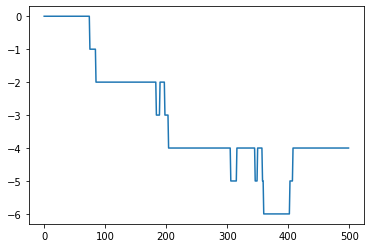

In [65]:
# price drift in sequence
plt.plot(onp.cumsum(b_seq[:, 0]))

In [107]:
def plot_l2_book(i_book, ax, xlim=None, ylim=None):
    i, book = i_book
    book = onp.array(book.reshape((-1, 2)))
    book[::2, 1] = book[::2, 1] * -1
    book = book[book[:, 0] != -1]

    ax.clear()
    plt.title("L2 Book: " + ticker + " - " + data_date + " - " + start_time_dt.strftime("%H:%M:%S"))
    plt.xlabel("Volume")
    plt.ylabel("Price")
    # option 2, remove all lines and collections
    # for artist in ax.lines + ax.collections:
    #     artist.remove()
    time_text = ax.text(
        0.05, 0.95, '#state: ' + str(i),
        horizontalalignment='left',verticalalignment='top',
        transform=ax.transAxes
    )
    
    bars = ax.barh(book[:, 0], book[:, 1], height=90, color='b')
    
    #xlim = ax.get_xlim()
    #x_abs_max = onp.max(onp.abs(xlim))
    #ax.set_xlim(-x_abs_max, x_abs_max)

    ylim = ax.get_ylim()
    p_mid = (book[0, 0] + book[1, 0]) / 2
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is None:
        y_half_range = onp.max((ylim[1] - p_mid, p_mid - ylim[0]))
        ax.set_ylim(p_mid + y_half_range, p_mid - y_half_range)
    else:
        ax.set_ylim(ylim)

    return bars

<BarContainer object of 19 artists>

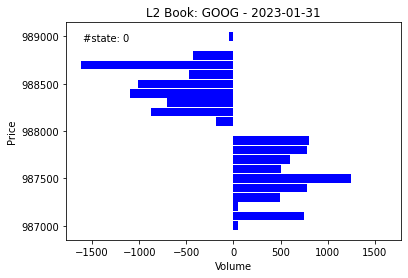

In [91]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
plt.title("L2 Book: " + ticker + " - " + data_date)
plt.xlabel("Volume")
plt.ylabel("Price")
max_vol = int(1.1 * onp.max(l2_book_states.reshape(l2_book_states.shape[0], -1, 2)[:, :, 1]))
xlim = (-max_vol, max_vol)

plot_l2_book((0, l2_book_states[1]), ax, xlim=xlim)

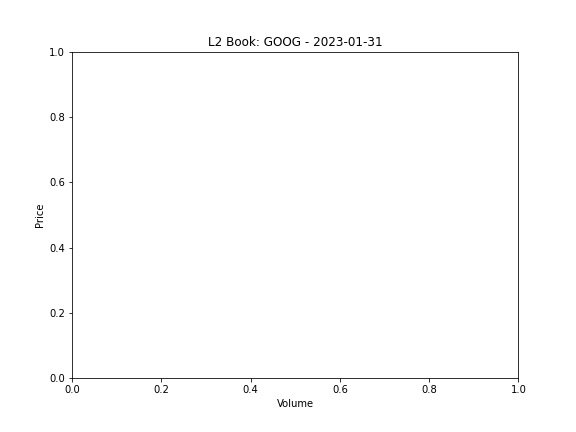

In [115]:
%matplotlib ipympl

import matplotlib.animation

max_vol = int(1.1 * onp.max(l2_book_states.reshape(l2_book_states.shape[0], -1, 2)[:, :, 1]))
xlim = (-max_vol, max_vol)

fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(111)
plt.title("L2 Book: " + ticker + " - " + data_date)
plt.xlabel("Volume")
plt.ylabel("Price")

ani = matplotlib.animation.FuncAnimation(
    fig,
    lambda b: plot_l2_book(b, ax, xlim=xlim),
    frames=list(enumerate(l2_book_states)),
    interval=200,
    repeat_delay=1000,
    #blit=True,
)
#plt.tight_layout()
plt.show()
ani.save(
    '../tmp/animation.webp',
    writer='imagemagick',
    fps=5,
    savefig_kwargs=dict(facecolor='#EAEAF2')
)

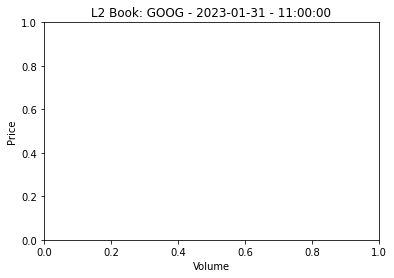

In [130]:
#pause
ani.event_source.stop()

#unpause
#ani.event_source.start()

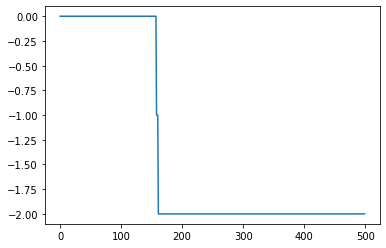

In [150]:
%matplotlib inline

# price drift in sequence
plt.plot(onp.cumsum(b_seq[:, 0]))

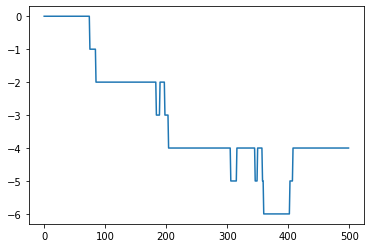

In [120]:
%matplotlib inline

# inspect movement of best bid price for sequence including
# generated flow at the end

# price drift in sequence
plt.plot(onp.cumsum(b_seq[:, 0]))

In [156]:
%matplotlib inline

l = Message_Tokenizer.MSG_LEN
decod_gen_msgs = tok.decode(m_seq.reshape((-1,l))[-100:], v)
decod_gen_msgs = pd.DataFrame(decod_gen_msgs, columns=Message_Tokenizer.FIELDS)
decod_gen_msgs

,time,event_type,size,price,direction,time_new,event_type_new,size_new,price_new,direction_new
0,5.399342e+12,1.0,100.0,-1.0,1.0,NaN,NaN,NaN,NaN,NaN
1,5.399282e+12,1.0,100.0,-2.0,1.0,5.399342e+12,3.0,100.0,-1.0,1.0
2,5.399350e+12,1.0,100.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
3,5.399282e+12,1.0,100.0,-2.0,1.0,5.399350e+12,3.0,100.0,-1.0,1.0
4,5.399257e+12,1.0,200.0,-1.0,1.0,5.399350e+12,2.0,100.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
95,5.399304e+12,1.0,600.0,4.0,0.0,5.399347e+12,2.0,51.0,6.0,0.0
96,5.399299e+12,1.0,100.0,-1.0,1.0,NaN,NaN,NaN,NaN,NaN
97,5.399334e+12,1.0,50.0,-7.0,1.0,5.399298e+12,3.0,50.0,-7.0,1.0
98,5.398295e+12,1.0,306.0,-8.0,1.0,NaN,NaN,NaN,NaN,NaN


In [160]:
%matplotlib inline
decod_gen_msgs['size'].value_counts().sort_index()

3.0       1
21.0      1
25.0      1
50.0     13
51.0     10
61.0      3
100.0    53
200.0    11
300.0     2
306.0     3
600.0     2
Name: size, dtype: int64

<AxesSubplot:>

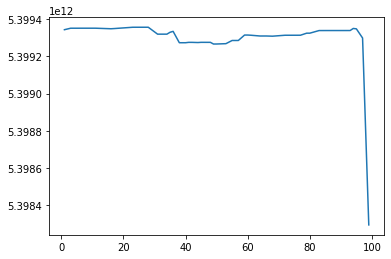

In [161]:
%matplotlib inline

# arriving mod times should be monotonically increasing...
decod_gen_msgs.dropna(subset=['time_new']).time_new.plot()

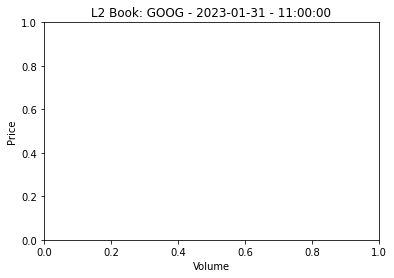

In [162]:
# new orders
new_orders = decod_gen_msgs.loc[decod_gen_msgs.time_new.isna()]

0     5.399342e+12
2     5.399350e+12
12    5.399350e+12
13    5.399346e+12
14    5.399346e+12
15    5.399348e+12
18    5.399372e+12
19    5.399354e+12
20    5.399355e+12
21    5.399355e+12
22    5.399355e+12
29    5.399313e+12
30    5.399317e+12
33    5.399318e+12
37    5.399256e+12
43    5.399273e+12
46    5.399271e+12
51    5.399265e+12
52    5.399265e+12
54    5.399256e+12
58    5.401286e+12
62    5.399311e+12
63    5.399308e+12
65    5.399309e+12
67    5.399309e+12
69    5.399308e+12
70    5.399312e+12
71    5.399312e+12
78    5.399324e+12
81    5.399338e+12
82    5.399338e+12
86    5.399338e+12
92    5.399338e+12
96    5.399299e+12
98    5.398295e+12
Name: time, dtype: float64

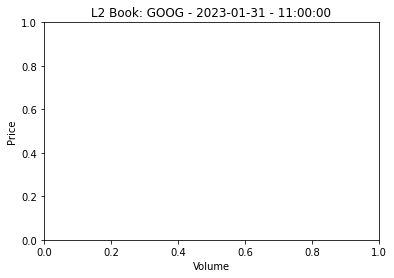

In [163]:
new_orders.time

<AxesSubplot:title={'center':'L2 Book: GOOG - 2023-01-31 - 11:00:00'}, xlabel='Volume', ylabel='Price'>

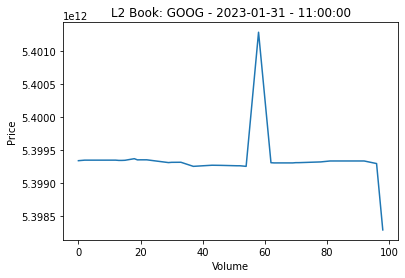

In [164]:
# error: should be monotonically increasing
new_orders.time.plot()

In [74]:
new_orders.event_type.value_counts()

1.0    65
Name: event_type, dtype: int64

In [75]:
# only order modifications
modif_orders = decod_gen_msgs.dropna()

In [76]:
modif_orders.event_type_new.value_counts()

3.0    22
2.0     9
4.0     2
Name: event_type_new, dtype: int64

### Model Validation (optional)

In [ ]:
dataset_obj = LOBSTER(
    'lobster',
    #data_dir='/nfs/home/peern/LOBS5/data/',
    data_dir='/nfs/home/peern/LOBS5/data/new_enc/',
    mask_fn=LOBSTER_Dataset.causal_mask,
    use_book_data=True,
    book_transform=True,
    msg_seq_len=500,
    n_cache_files=100,
)
dataset_obj.setup()

In [ ]:
test_loader = make_data_loader(
    dataset_obj.dataset_test,
    dataset_obj,
    seed=args.jax_seed,
    batch_size=args.bsz,
    drop_last=True,
    shuffle=False,
    num_workers=0
)

In [26]:
rng = jax.random.PRNGKey(42)
tok = Message_Tokenizer()

all_pred_toks = []
all_labels = []

losses = []
accuracy = []
ranks = []
valid_mass = []
valid_mass_n5 = []
valid_pred = []
losses_baseline = []

VALID_MATRIX = valh.syntax_validation_matrix()

for batch_idx, batch in enumerate(tqdm(test_loader)):
    
    # PREPARE BATCH
    inputs, labels, integration_timesteps = prep_batch(batch, seq_len, n_classes, num_devices=1)
    # INFERENCE STEP
    loss, acc, pred = eval_step(
        inputs, labels, integration_timesteps, par_state, model.apply, args.batchnorm)

    loss = loss.squeeze(axis=0)
    acc = acc.squeeze(axis=0)
    pred = pred.squeeze(axis=0)
    
    # STORE RESULTS
    pred_toks = pred.argmax(axis=-1)
    all_labels += labels.tolist()
    all_pred_toks += pred_toks.tolist()
    
    # STATS
    losses.append(cross_entropy_loss(pred, labels))
    accuracy.append(compute_accuracy(pred, labels))
    
    # where does the correct label rank in the predicted distribution?
    ranks.append(valh.pred_rank(pred, labels))
    # how much of the predicted distribution is valid?
    masked_fields = valh.get_masked_fields(batch[0])
    valid_mass.append(valh.valid_prediction_mass(pred, masked_fields))
    valid_mass_n5.append(valh.valid_prediction_mass(pred, masked_fields, top_n=5))

    # check if argmax prediction is valid token for masked fields
    valid_pred.append(valh.is_tok_valid(pred_toks, masked_fields, v))

    # benchmark: uniform prediction over syntactically valid tokens
    pos = valh.get_masked_idx(batch[0])[..., -1]
    baseline_distr = VALID_MATRIX[pos] / VALID_MATRIX[pos].sum(axis=-1, keepdims=True)
    losses_baseline.append(cross_entropy_loss(jnp.log(
            jnp.where(baseline_distr==0, 1e-10, baseline_distr)
        ), labels)
    )

all_labels = jnp.array(all_labels)
all_pred_toks = jnp.array(all_pred_toks)
losses = jnp.array(losses)
accuracy = jnp.array(accuracy)
ranks = jnp.array(ranks)
valid_mass = jnp.array(valid_mass)
valid_mass_n5 = jnp.array(valid_mass_n5)
valid_pred = jnp.array(valid_pred)
losses_baseline = jnp.array(losses_baseline)

NameError: name 'test_loader' is not defined

In [ ]:
print('mean loss', losses.mean())
print('mean accuracy', accuracy.mean())
print('mean rank', ranks.mean())
print('median rank', onp.median(ranks))
print('mean valid mass', valid_mass.mean())
print('mean valid mass (top 5)', valid_mass_n5.mean())
print('mean valid prediction', valid_pred.mean())
print('mean baseline loss (uniform over valid syntax)', losses_baseline.mean())

mean loss 1.4749558
mean accuracy 0.688901
mean rank 72.28813
median rank 0.0
mean valid mass 0.971541
mean valid mass (top 5) 0.9579046
mean valid prediction 0.98988515
mean baseline loss (uniform over valid syntax) 5.2721515


In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as onp
import pandas as pd


precision, recall, fscore, support = precision_recall_fscore_support(
    all_labels.astype(int),
    all_pred_toks,
    labels=range(len(v)),
    zero_division=0,
    average=None
)

'''
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
'''

"\nprint('precision: {}'.format(precision))\nprint('recall: {}'.format(recall))\nprint('fscore: {}'.format(fscore))\nprint('support: {}'.format(support))\n"

In [ ]:
field_dec = onp.array([(field, dec) for tok, (field, dec) in sorted(v.DECODING_GLOBAL.items())])

scores_df = pd.DataFrame({
    'field': field_dec[:, 0],
    'decoded': field_dec[:, 1],
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support,
})
#scores_df

In [ ]:
# left to right causal prediction:

scores_df.loc[scores_df.support > 0].groupby('field').agg(
    precision=('precision', 'mean'),
    recall=('recall', 'mean'),
    fscore=('fscore', 'mean'),
    support=('support', 'sum'),
)

,precision,recall,fscore,support
field,,,,
direction,0.624236,0.632841,0.626838,436
event_type,0.393960,0.399946,0.396617,465
generic,1.000000,0.998603,0.999301,716
price,0.557158,0.452684,0.477146,676
size,0.213366,0.152106,0.170773,680
time,0.011118,0.037804,0.016177,685
